First, import needed Python libraries.

In [1]:
# Import NumPy, a Python library for numerical computing.
import numpy as np

# Import and configure Matplotlib, a Python library for plotting output.
import matplotlib.pyplot as plt
plt.style.use('ggplot')

Next, define a function `householder` that takes an $m \times n$ real matrix $A$ (with $m\geq n$) as its argument and outputs the $QR$ factorization of $A$.

In [2]:
def householder(A):
    (m,n) = A.shape
    
    # Define initial placeholder arrays for Q and R.
    Q = np.identity(m)
    R = A
    
    # Iterate over first (n-1) columns in A, calculating the household reflector Qk
    # for each step and applying it to the array R.
    for k in range(1,n):
        # Define vector x as the kth column vector in R.
        x = R[(k-1):,(k-1)]
        
        # Calculate vector v with equation 10.5 in (Trefethen and Bau 1997).
        if x[0] >= 0:
            z = 1
        else:
            z = -1
        v = np.pad(np.array([z*np.linalg.norm(x)]),(0,m-k),'constant') + x
        
        # Calculate matrix F with equation 10.4 in (Trefethen and Bau 1997).
        F = np.identity(m-k+1) - 2*np.outer(v,v)/np.dot(v,v)
        
        # Calculate matrix Qk with equation 10.2 in (Trefethen and Bau 1997).
        Qk = np.identity(m)
        Qk[(k-1):(m+1),(k-1):(m+1)] = F
        
        # Left-multiply the matrix Qk against Q and R, which are returned once this
        # for loop is completed.
        Q = np.matmul(Q,Qk.transpose())
        R = np.matmul(Qk,R)
    
    # Return function results.
    return Q,R

Apply the function `householder` to a random matrix to test it.

In [3]:
A = np.random.rand(5,3)
(Q,R) = householder(A)
print('A =\n',A,'\nQ =\n',Q,'\nR =\n',R)

A =
 [[ 0.6754163   0.56753773  0.88274091]
 [ 0.16971541  0.29413696  0.76627244]
 [ 0.73506095  0.33786427  0.31510963]
 [ 0.56552764  0.42945009  0.0186401 ]
 [ 0.68760441  0.49085668  0.31296339]] 
Q =
 [[-0.50093732 -0.36750325 -0.42991044 -0.42458092 -0.49891003]
 [-0.12587316 -0.65669856  0.73953146 -0.07022589  0.03262651]
 [-0.54517408  0.64209964  0.47387328 -0.13770306 -0.21673776]
 [-0.41943598 -0.1373178  -0.10362395  0.88061399 -0.1378345 ]
 [-0.50997689 -0.05040079 -0.1815941  -0.14267524  0.82707357]] 
R =
 [[ -1.34830502e+00  -9.35972008e-01  -8.77863021e-01]
 [ -1.83445505e-16  -2.68499466e-01  -6.43621603e-01]
 [ -1.73877149e-16   1.45283091e-17   2.77741213e-01]
 [ -1.00533438e-16  -1.15196481e-19  -5.00236069e-01]
 [ -1.03732668e-16   0.00000000e+00  -2.27429157e-01]]


Define a function `rand_mat` that generates a random $m \times m$ matrix with condition number $\kappa$.

In [4]:
def rand_mat(kappa, m):
    
    # Assume the minimum singular value and calculate the maximum singular value.
    min_sing_val = 0.01
    max_sing_val = kappa*min_sing_val
    
    # Generate the other singular values by assuming a uniform distribution between
    # the maximum and minimum singular values.
    sing_vals =  sorted(np.random.uniform(min_sing_val,max_sing_val,m),reverse=True)
    sing_vals[-1] = min_sing_val
    sing_vals[0] = max_sing_val
    
    # Form diagonal matrix S with the singular values.
    S = np.diag(sing_vals)
    
    # Generate random orthoganal matrices U and V by taking the QR decomposition of
    # random m by m matrices.
    (U,R) = np.linalg.qr(np.random.rand(m,m))
    (V,R) = np.linalg.qr(np.random.rand(m,m))

    # Calculate the random m by m matrix A, using the SVD decomposition.
    A = U@S@V

    return A

Test the function `rand_mat`.

In [5]:
A = rand_mat(10**4,5)
kappa = np.linalg.cond(A)
print('A = \n',A,'\ncondition number of A = ',kappa)

A = 
 [[-36.74508544 -51.15892515   2.02594931 -12.12682216 -16.71672353]
 [ 39.03170018 -39.83611658 -20.88596474 -34.92231228  11.90594089]
 [ 36.25764135  -5.467201    10.95888418 -36.83683813  -8.84907183]
 [ -5.70287854 -13.76985935  36.96387913 -17.63119267  51.39091499]
 [ 23.01326516 -22.62096814  15.55129014 -45.82019479 -28.13247732]] 
condition number of A =  10000.0


Examine the relationship between the condition number of a matrix $A \in \mathbb{R}^{5\times 5}$ and the relative condition number of its Householder $QR$ decomposition by performing the following steps:
1. Generate 300 random 5 by 5 matrices $A$ with condition numbers $\kappa_A$ ranging from $10 \leq \kappa_A \leq 10^{16}$ using the previously defined function `rand_mat`.
2. Generate a perturbed version of each matrix $A$, called $A_p$, where each element of $A$ has been perturbed by an amount $(1+\epsilon)$, where $\epsilon$ is randomly sampled from a uniform distribution between 0 and 0.001.
3. Calculate the $QR$ decomposition of each $A$ and $A_p$, generating matrices $Q$, $R$, $Q_p$, and $R_p$.
4. Estimate the relative condition number of each $Q$ and $R$ via the following equations:
 $$\kappa_Q \geq \kappa'_Q = \left ( \frac{\left \| \Delta Q \right \|_2}{\left \| Q \right \|_2} \right ) \left ( \frac{\left \| \Delta A \right \|_2}{\left \| A \right \|_2} \right )^{-1}$$
 $$\kappa_R \geq \kappa'_R = \left ( \frac{\left \| \Delta R \right \|_2}{\left \| R \right \|_2} \right ) \left ( \frac{\left \| \Delta A \right \|_2}{\left \| A \right \|_2} \right )^{-1}$$
 where $\Delta Q = Q_p - Q$, $\Delta R = R_p - R$, and $\Delta A = A - A_p$.
5. Create plots of $\kappa'_Q$ and $\kappa'_R$ versus $\kappa_A$, where each of the 300 randomly generated matrices $A$ is a single data point.

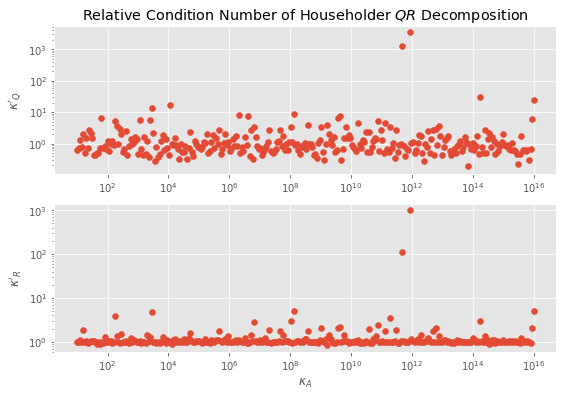

In [6]:
m = 5 # number of rows and columns of matrices A

# Define range of condition numbers to use when generating random matrices A.
kappas = np.logspace(1,16,300)

# Define empty arrays to hold the relative condition numbers (RCN) of the QR
# decomposition of A.
rcn_Q = np.array([])
rcn_R = np.array([])

# Iterate over each condition number in kappas, generating a random matrix, performing a
# Householder QR decomposition, and then calculating the RCN of Q and R.
for kappa in kappas:
    # Generate random matrix A with specified condition number kappa and row/column size m.
    A = rand_mat(kappa,m)
    
    # Generate a random m by m perturbation matrix E, where each element is randomly
    # sampled from a uniform distribution between 0 and 0.001.
    E = np.random.uniform(0,0.001,m**2)
    E = np.reshape(E,(m,m))
    
    # Calculate a perturbed version of matrix A, Ap, by calculating the element by element
    # product of A times (1 + E).
    Ap = A*(1+E)
    
    # Calculate the householder QR decompositions of A and Ap.
    (Q,R) = householder(A)
    (Qp,Rp) = householder(Ap)
    
    # Calculate the spectral norm of A and the amount that A was perturbed, dA.
    norm_A = np.linalg.norm(A, ord=2)
    norm_dA = np.linalg.norm(Ap-A, ord=2)
    
    # Calculate the spectral norm of Q and the amount that Q was perturbed, dQ. 
    norm_Q = np.linalg.norm(Q, ord=2)
    norm_dQ = np.linalg.norm(Qp-Q, ord=2)
    
    # Calculate the spectral norm of R and the amount that R was perturbed, dR.
    norm_R = np.linalg.norm(R, ord=2)
    norm_dR = np.linalg.norm(Rp-R, ord=2)
    
    # Calculate the relative condition numbers of Q and R, then append them to the arrays
    # rcn_Q and rcn_R.
    rcn_Q = np.append(rcn_Q,(norm_dQ/norm_Q)/(norm_dA/norm_A))
    rcn_R = np.append(rcn_R,(norm_dR/norm_R)/(norm_dA/norm_A))

# Plot output.
fig,(ax0,ax1) = plt.subplots(nrows=2, ncols=1, figsize=[9,6])
ax0.scatter(kappas,rcn_Q)
ax0.set_xscale('log')
ax0.set_yscale('log')
ax0.set_title('Relative Condition Number of Householder $QR$ Decomposition')
ax0.set_ylabel('$\kappa\'_Q$')
ax1.scatter(kappas,rcn_R)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('$\kappa_A$')
ax1.set_ylabel('$\kappa\'_R$')
plt.show()

The project assignment states that "the maps from $A$ onto $Q$ and $R$ can be ill-conditioned even when A is very well-conditioned". That is not the behavior exhibited in the plots above, however, which show that the aforementioned maps are well-conditioned even when $A$ is highly ill-conditioned.

Just in case this lack of ill-conditioning in $A \mapsto Q$ and $A \mapsto R$ is a result of how I generate my random matrices $A$ with the function `rand_mat`, I will now test a new method of generating matrices with varying condition number:
1. Generate a random matrix $A \in \mathbb{R}^{5\times 5}$ with values ranging from 0 to 10.
2. Replace the fifth column vector in $A$, $a_5$, with the fourth column vector $a_4$ to turn $A$ into a singular matrix.
3. Offset each value in $a_5$ by the same value $\delta a$, where $\delta a$ ranges from $10$ to $10^{-15}$. A higher $\delta a$ value should correspond to a higher
4. Calculate the condition number $\kappa_A$ of each matrix $A$ and plot it as a function of $\delta a$.

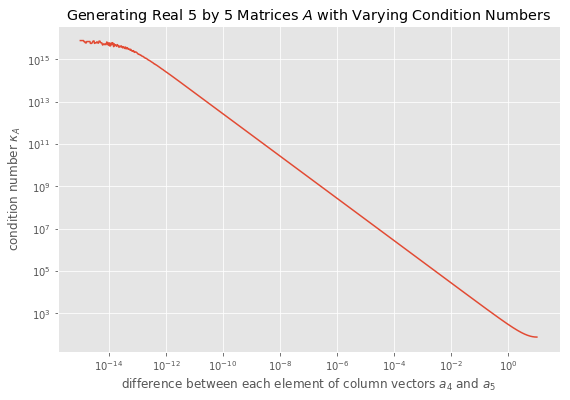

In [7]:
# Generate random 5 by 5 matrix A containing values ranging from 0 to 10.
A = 10*np.random.rand(5,5)

# Replace fifth column vector in A with a copy of the fourth column vector.
A[:,-1] = A[:,-2]

# Generate a range of delta a values.
deltas = np.logspace(1,-15,1000)

# Define an empty array kappas that will hold the condition numbers of the matrices.
kappas = np.array([])

# Iterate over the range of delta a values, perturbing the fifth column slightly and
# calculating the condition number.
for delta in deltas:
    A[:,-1] = A[:,-1] + delta
    kappa = np.linalg.cond(A)
    kappas = np.append(kappas,kappa)
    A[:,-1] = A[:,-1] - delta

# Plot output.
fig,ax = plt.subplots(figsize=[9,6])
ax.loglog(deltas,kappas)
ax.set_title('Generating Real 5 by 5 Matrices $A$ with Varying Condition Numbers')
ax.set_xlabel('difference between each element of column vectors $a_4$ and $a_5$')
ax.set_ylabel('condition number $\kappa_A$')
plt.show()

As expected, a smaller difference between the column vectors $a_4$ and $a_5$ leads to a larger condition number $\kappa_A$.

Utilize the previously discussed method for generating matrices $A$ with varying condition numbers to create a new function `rand_mat_v2`.

In [8]:
def rand_mat_v2(delta, m):
    A = 10*np.random.rand(m,m)
    A[:,-1] = A[:,-2] + delta
    return A

Repeat the same analysis from before of the conditioning of $A \mapsto Q$ and $A \mapsto R$, substituting the new function `rand_mat_v2` for `rand_mat`.

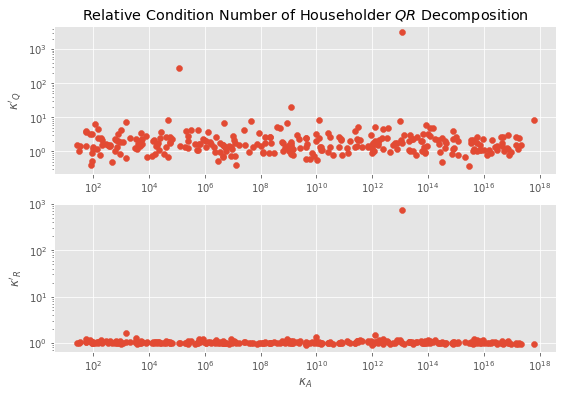

In [9]:
m = 5 # number of rows and columns of matrices A

# Define range of delta values to use when generating random matrices A. This value
# corresponds to the difference between each element of column vectors a_4 and a_5 in
# matrix A. A higher delta value corresponds to a lower condition number for matrix A.
deltas = np.logspace(1,-15,300)

# Define empty arrays to hold the condition numbers of A and A's Householder QR
# decomposition.
kappas = np.array([])
rcn_Q = np.array([])
rcn_R = np.array([])

# Iterate over each value in deltas, generating a random matrix, performing a
# Householder QR decomposition, and then calculating the RCN of Q and R.
for delta in deltas:
    # Generate random matrix A with specified row/column size m and conditioning
    # parameter delta.
    A = rand_mat_v2(delta,m)
    kappas = np.append(kappas,np.linalg.cond(A))
    
    # Generate a random m by m perturbation matrix E, where each element is randomly
    # sampled from a uniform distribution between 0 and 0.001.
    E = np.random.uniform(0,0.001,m**2)
    E = np.reshape(E,(m,m))
    
    # Calculate a perturbed version of matrix A, Ap, by calculating the element by
    # element product of A times (1 + E).
    Ap = A*(1+E)
    
    # Calculate the householder QR decompositions of A and Ap.
    (Q,R) = householder(A)
    (Qp,Rp) = householder(Ap)
    
    # Calculate the spectral norm of A and the amount that A was perturbed, dA.
    norm_A = np.linalg.norm(A, ord=2)
    norm_dA = np.linalg.norm(Ap-A, ord=2)
    
    # Calculate the spectral norm of Q and the amount that Q was perturbed, dQ. 
    norm_Q = np.linalg.norm(Q, ord=2)
    norm_dQ = np.linalg.norm(Qp-Q, ord=2)
    
    # Calculate the spectral norm of R and the amount that R was perturbed, dR.
    norm_R = np.linalg.norm(R, ord=2)
    norm_dR = np.linalg.norm(Rp-R, ord=2)
    
    # Calculate the relative condition numbers of Q and R, then append them to
    # the arrays rcn_Q and rcn_R.
    rcn_Q = np.append(rcn_Q,(norm_dQ/norm_Q)/(norm_dA/norm_A))
    rcn_R = np.append(rcn_R,(norm_dR/norm_R)/(norm_dA/norm_A))

# Plot output.
fig,(ax0,ax1) = plt.subplots(nrows=2, ncols=1, figsize=[9,6])
ax0.scatter(kappas,rcn_Q)
ax0.set_xscale('log')
# ax0.set_xlim([10**-15,10])
ax0.set_yscale('log')
ax0.set_title('Relative Condition Number of Householder $QR$ Decomposition')
ax0.set_ylabel('$\kappa\'_Q$')
ax1.scatter(kappas,rcn_R)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('$\kappa_A$')
ax1.set_ylabel('$\kappa\'_R$')
plt.show()

As in the previous round of analysis, $A \mapsto Q$ and $A \mapsto R$ do not show ill-conditioning, nor does their conditioning appear to be dependent on the condition number of $A$.